####Importing Libraries

In [32]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

####Data_Load

In [33]:
data=pd.read_csv('/content/drive/MyDrive/9_Donors_choose_DT/preprocessed_data.csv',nrows=15000)

print(data.shape)
print(data.columns.values)

(15000, 9)
['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price']


####Train,CV,Test Split

In [34]:
from sklearn.model_selection import train_test_split
Y=data['project_is_approved'].values
X=data.drop(['project_is_approved'],axis=1)
print(X.shape)
print(Y.shape)
x_train1,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,stratify=Y)
print(x_train1.shape,y_train.shape)
x_train,x_cv,y_train,y_cv=train_test_split(x_train1,y_train,test_size=0.2,stratify=y_train)
print(x_train.shape,x_test.shape)
print(x_cv.shape,y_cv.shape)
print(y_train.shape,y_test.shape)

(15000, 8)
(15000,)
(12000, 8) (12000,)
(9600, 8) (3000, 8)
(2400, 8) (2400,)
(9600,) (3000,)


####Essay_features with Tfidf

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
print(x_train.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)
print(x_test.shape, y_test.shape)
print("="*100)

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,1), max_features=5000)
vectorizer.fit(x_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_essay_tfidf = vectorizer.transform(x_train['essay'].values)
x_cv_essay_tfidf = vectorizer.transform(x_cv['essay'].values)
x_test_essay_tfidf = vectorizer.transform(x_test['essay'].values)
print("After vectorizations")
print(x_train_essay_tfidf.shape, y_train.shape)
print(x_cv_essay_tfidf.shape, y_cv.shape)
print(x_test_essay_tfidf.shape, y_test.shape)
print("="*100)
#print(x_train_essay_tfidf.columns.value)

(9600, 8) (9600,)
(2400, 8) (2400,)
(3000, 8) (3000,)
After vectorizations
(9600, 5000) (9600,)
(2400, 5000) (2400,)
(3000, 5000) (3000,)


In [36]:
with open('/content/drive/MyDrive/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [37]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['essay'].values)
len1=x_train['essay'].shape
print(len1)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
tfidf_w2v_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in x_train['essay']: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_tr.append(vector)
tfidf_w2v_vectors_tr=np.array(tfidf_w2v_vectors_tr)
#print(tfidf_w2v_vectors.shape)
print(tfidf_w2v_vectors_tr.shape)
tfidf_model.fit(x_cv['essay'].values)
len_cv=x_cv['essay'].shape
print(len_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in x_cv['essay']: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)
#print(type(tfidf_w2v_vectors_cv))
#print(tfidf_w2v_vectors.shape)
#print(len(tfidf_w2v_vectors_cv))
tfidf_w2v_vectors_cv=np.array(tfidf_w2v_vectors_cv)
print(tfidf_w2v_vectors_cv.shape)
tfidf_model.fit(x_test['essay'].values)
len_te=x_test['essay'].shape
print(len_te)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
tfidf_w2v_vectors_te = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in x_test['essay']: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_te.append(vector)
tfidf_w2v_vectors_te=np.array(tfidf_w2v_vectors_te)
print(tfidf_w2v_vectors_te.shape)

(9600,)
(9600, 300)
(2400,)
(2400, 300)
(3000,)
(3000, 300)


####Catagorical Features

####Teacher_prefix

In [38]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_teacher_ohe = vectorizer.transform(x_train['teacher_prefix'].values)
x_cv_teacher_ohe = vectorizer.transform(x_cv['teacher_prefix'].values)
x_test_teacher_ohe = vectorizer.transform(x_test['teacher_prefix'].values)

print("After vectorizations")
print(x_train_teacher_ohe.shape, y_train.shape)
print(x_cv_teacher_ohe.shape, y_cv.shape)
print(x_test_teacher_ohe.shape, y_test.shape)
print("="*100)

After vectorizations
(9600, 5) (9600,)
(2400, 5) (2400,)
(3000, 5) (3000,)


####Project_grade_catagory

In [39]:
#project_grade_catagory
vectorizer = CountVectorizer()
vectorizer.fit(x_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_project_grade_category = vectorizer.transform(x_train['project_grade_category'].values)
x_cv_project_grade_category = vectorizer.transform(x_cv['project_grade_category'].values)
x_test_project_grade_category = vectorizer.transform(x_test['project_grade_category'].values)

print("After vectorizations")
print(x_train_project_grade_category.shape, y_train.shape)
print(x_cv_project_grade_category.shape, y_cv.shape)
print(x_test_project_grade_category.shape, y_test.shape)
print("="*100)

After vectorizations
(9600, 4) (9600,)
(2400, 4) (2400,)
(3000, 4) (3000,)


####School_State

In [40]:
#school_state
vectorizer = CountVectorizer()
vectorizer.fit(x_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_school_state = vectorizer.transform(x_train['school_state'].values)
x_cv_school_state = vectorizer.transform(x_cv['school_state'].values)
x_test_school_state = vectorizer.transform(x_test['school_state'].values)

print("After vectorizations")
print(x_train_school_state.shape, y_train.shape)
print(x_cv_school_state.shape, y_cv.shape)
print(x_test_school_state.shape, y_test.shape)
print("="*100)


After vectorizations
(9600, 51) (9600,)
(2400, 51) (2400,)
(3000, 51) (3000,)


In [41]:
#clean_catagories
vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_clean_categories = vectorizer.transform(x_train['clean_categories'].values)
x_cv_clean_categories = vectorizer.transform(x_cv['clean_categories'].values)
x_test_clean_categories = vectorizer.transform(x_test['clean_categories'].values)

print("After vectorizations")
print(x_train_clean_categories.shape, y_train.shape)
print(x_cv_clean_categories.shape, y_cv.shape)
print(x_test_clean_categories.shape, y_test.shape)
print("="*100)

After vectorizations
(9600, 7) (9600,)
(2400, 7) (2400,)
(3000, 7) (3000,)


In [42]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_clean_subcategories = vectorizer.transform(x_train['clean_subcategories'].values)
x_cv_clean_subcategories = vectorizer.transform(x_cv['clean_subcategories'].values)
x_test_clean_subcategories = vectorizer.transform(x_test['clean_subcategories'].values)

print("After vectorizations")
print(x_train_clean_subcategories.shape, y_train.shape)
print(x_cv_clean_subcategories.shape, y_cv.shape)
print(x_test_clean_subcategories.shape, y_test.shape)
print("="*100)

After vectorizations
(9600, 28) (9600,)
(2400, 28) (2400,)
(3000, 28) (3000,)


####Numerical_Features

In [43]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(x_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(x_train['price'].values.reshape(1,-1))

x_train_price_norm = normalizer.transform(x_train['price'].values.reshape(1,-1))
x_cv_price_norm = normalizer.transform(x_cv['price'].values.reshape(1,-1))
x_test_price_norm = normalizer.transform(x_test['price'].values.reshape(1,-1))


x_train_price_norm=x_train_price_norm.reshape(-1,1)
x_test_price_norm=x_test_price_norm.reshape(-1,1)
x_cv_price_norm=x_cv_price_norm.reshape(-1,1)
print("After vectorizations")
print(x_train_price_norm.shape, y_train.shape)
print(x_cv_price_norm.shape, y_cv.shape)
print(x_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(9600, 1) (9600,)
(2400, 1) (2400,)
(3000, 1) (3000,)


In [44]:
#teacher_number_of_previously_posted_projects
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
x_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
x_cv_teacher_number_of_previously_posted_projects_norm = normalizer.transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
x_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
print("After vectorizations")
x_train_teacher_number_of_previously_posted_projects_norm=x_train_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)
x_cv_teacher_number_of_previously_posted_projects_norm=x_cv_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)
x_test_teacher_number_of_previously_posted_projects_norm=x_test_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)
print(x_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(x_cv_teacher_number_of_previously_posted_projects_norm.shape, y_cv.shape)
print(x_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(9600, 1) (9600,)
(2400, 1) (2400,)
(3000, 1) (3000,)


####Sentiment Score

In [45]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [46]:
import nltk
import numpy as np
from scipy.sparse import hstack
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
#nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
lim=X['essay'].shape[0]
#print(str(X['essay'][0]))
#print(lim)
#ss={}
neg=[]
neu=[]
pos=[]
compound=[]
for i in range(lim):
  ss = sid.polarity_scores(str(X['essay'][i]))
  new_list=list(ss.items())
  d=new_list[0]
  neg.append(d[1])
  l=new_list[1]
  neu.append(l[1])
  k=new_list[2]
  pos.append(k[1])
  j=new_list[3]
  compound.append(j[1])
neu=np.array(neu)
neu_tf=neu.reshape(-1,1)
print(neu_tf.shape)
neg=np.array(neg)
neg_tf=neg.reshape(-1,1)
print(neg_tf.shape)
pos=np.array(pos)
pos_tf=pos.reshape(-1,1)
print(pos_tf.shape)
compound=np.array(compound)
compound_tf=compound.reshape(-1,1)
print(compound_tf.shape)
ss_score=np.hstack((neu_tf,neg_tf,pos_tf,compound_tf))
print(ss_score.shape)
#ss_score_tr=np.reshape(ss_score,())
ss_score_train,ss_score_cv,ss_score_test=ss_score[:x_train.shape[0], ],ss_score[x_train.shape[0]:x_cv.shape[0]+x_train.shape[0],],ss_score[x_cv.shape[0]+x_train.shape[0]:x_cv.shape[0]+x_train.shape[0]+x_test.shape[0],]
print(ss_score_train.shape)
print(ss_score_cv.shape)
print(ss_score_test.shape)

  #ss
#for k in ss:#print('{0}: {1}, '.format(k, ss[k]), end='')
#print(ss)
# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

(15000, 1)
(15000, 1)
(15000, 1)
(15000, 1)
(15000, 4)
(9600, 4)
(2400, 4)
(3000, 4)


In [47]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
x_tr_tfidf=hstack((x_train_essay_tfidf ,x_train_teacher_ohe,x_train_project_grade_category,x_train_school_state,x_train_clean_subcategories,x_train_price_norm,x_train_teacher_number_of_previously_posted_projects_norm,ss_score_train)).tocsr()
x_cv_tfidf=hstack((x_cv_essay_tfidf ,x_cv_teacher_ohe,x_cv_project_grade_category,x_cv_school_state,x_cv_clean_subcategories,x_cv_price_norm,x_cv_teacher_number_of_previously_posted_projects_norm,ss_score_cv)).tocsr()
x_te_tfidf=hstack((x_test_essay_tfidf ,x_test_teacher_ohe,x_test_project_grade_category,x_test_school_state,x_test_clean_subcategories,x_test_price_norm,x_test_teacher_number_of_previously_posted_projects_norm,ss_score_test)).tocsr()
print("Final Data matrix")
print(x_tr_tfidf.shape, y_train.shape)
print(x_cv_tfidf.shape, y_cv.shape)
print(x_te_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(9600, 5094) (9600,)
(2400, 5094) (2400,)
(3000, 5094) (3000,)


In [48]:
x_tr_tfidf_w2v=hstack((tfidf_w2v_vectors_tr ,x_train_teacher_ohe,x_train_project_grade_category,x_train_school_state,x_train_clean_subcategories,x_train_price_norm,x_train_teacher_number_of_previously_posted_projects_norm,ss_score_train)).tocsr()
x_cv_tfidf_w2v=hstack((tfidf_w2v_vectors_cv ,x_cv_teacher_ohe,x_cv_project_grade_category,x_cv_school_state,x_cv_clean_subcategories,x_cv_price_norm,x_cv_teacher_number_of_previously_posted_projects_norm,ss_score_cv)).tocsr()
x_te_tfidf_w2v=hstack((tfidf_w2v_vectors_te ,x_test_teacher_ohe,x_test_project_grade_category,x_test_school_state,x_test_clean_subcategories,x_test_price_norm,x_test_teacher_number_of_previously_posted_projects_norm,ss_score_test)).tocsr()
print("Final Data matrix")
print(x_tr_tfidf_w2v.shape, y_train.shape)
print(x_cv_tfidf_w2v.shape, y_cv.shape)
print(x_te_tfidf_w2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(9600, 394) (9600,)
(2400, 394) (2400,)
(3000, 394) (3000,)


####Hyperparameter Tuning

####HyperParameter Tunning for Set1

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  3.3min finished


{'max_depth': 10, 'min_samples_split': 500}


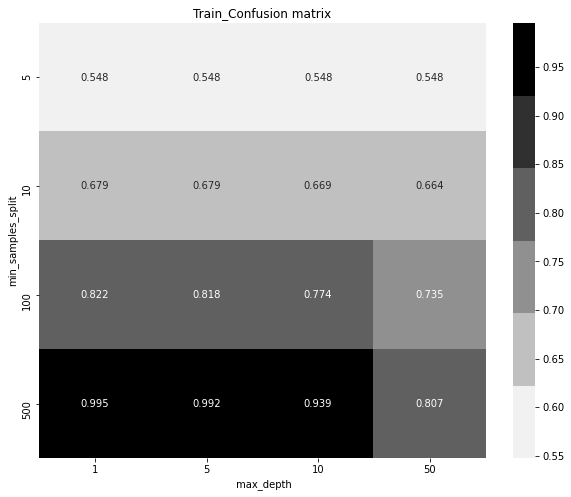

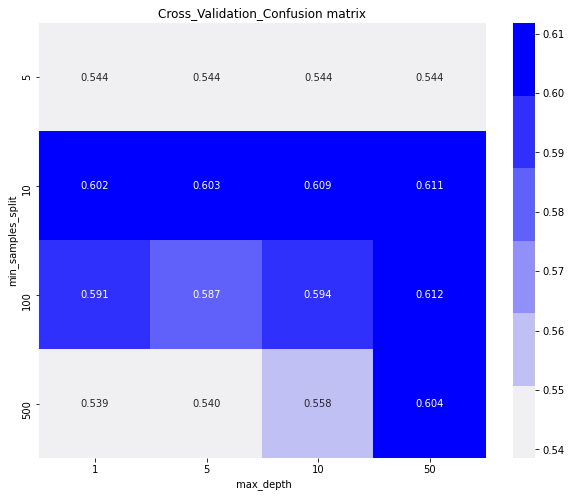

In [49]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import math
auc_score=[]
depth= [1, 5, 10, 50]
min_samples_split=[5,10,100,500]
Decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight='balanced', presort='deprecated', ccp_alpha=0.0)
#decision_tree.fit(x_tr_tfidf,y_train)
param_dict={'max_depth':[1, 5, 10, 50],'min_samples_split':[5,10,100,500]}

grid=GridSearchCV(Decision_tree,param_grid=param_dict,cv=10,verbose=1,n_jobs=-1,scoring='roc_auc',return_train_score=True)
#alpha_n_tfidf=[math.log(y,10) for y in alpha] 
grid.fit(x_tr_tfidf,y_train) 
print(grid.best_params_)
results=grid.cv_results_
#print(results.keys())
train_auc=results['mean_train_score']
cv_auc=results['mean_test_score']
train_auc=np.array(train_auc)
auc_train=train_auc.reshape(4,4)
import seaborn as sns
plt.figure(figsize=(10,8))
cmap=sns.light_palette("black")
sns.heatmap(auc_train, annot=True, cmap=cmap, fmt=".3f", xticklabels=depth, yticklabels=min_samples_split)
plt.xlabel(' max_depth')
plt.ylabel('min_samples_split')
plt.title("Train_Confusion matrix")
plt.show()
cv_auc=np.array(cv_auc)
auc_cv=cv_auc.reshape(4,4)
plt.figure(figsize=(10,8))
cmap=sns.light_palette("blue")
sns.heatmap(auc_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=depth, yticklabels=min_samples_split)
plt.xlabel(' max_depth')
plt.ylabel('min_samples_split')
plt.title("Cross_Validation_Confusion matrix")
plt.show()

####HyperParameter Tunning for Set2

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  6.7min finished


{'max_depth': 10, 'min_samples_split': 500}


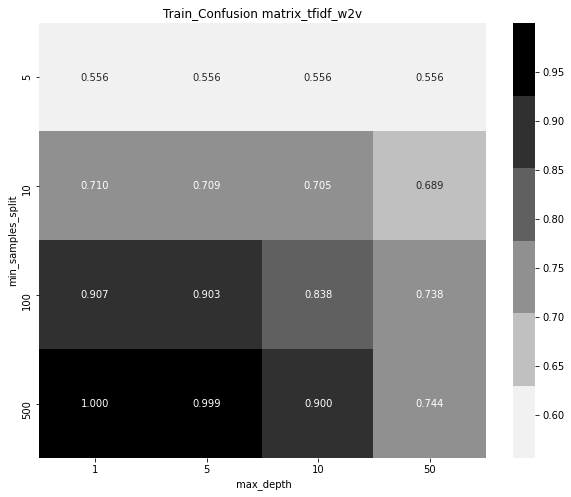

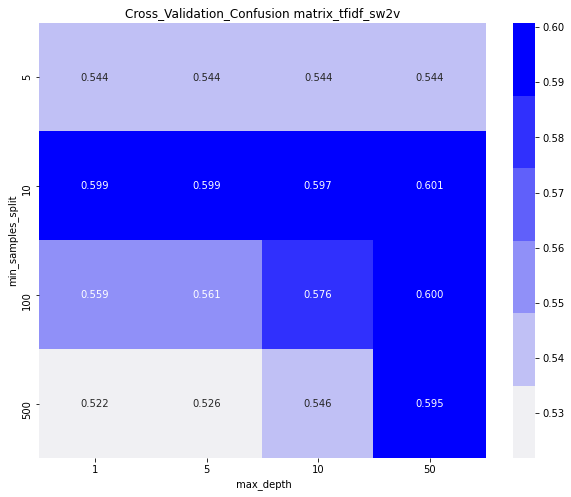

In [50]:
min_samples_split=[5,10,100,500]
Decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight='balanced', presort='deprecated', ccp_alpha=0.0)
#decision_tree.fit(x_tr_tfidf,y_train)
param_dict={'max_depth':[1, 5, 10, 50],'min_samples_split':[5,10,100,500]}

grid_w2v=GridSearchCV(Decision_tree,param_grid=param_dict,cv=10,verbose=1,n_jobs=-1,scoring='roc_auc',return_train_score=True)
#alpha_n_tfidf=[math.log(y,10) for y in alpha] 
grid_w2v.fit(x_tr_tfidf_w2v,y_train) 
print(grid.best_params_)
results=grid_w2v.cv_results_
#print(results.keys())
train_auc_w2v=results['mean_train_score']
cv_auc_w2v=results['mean_test_score']
train_auc_w2v=np.array(train_auc_w2v)
auc_train_w2v=train_auc_w2v.reshape(4,4)
import seaborn as sns
plt.figure(figsize=(10,8))
cmap=sns.light_palette("black")
sns.heatmap(auc_train_w2v, annot=True, cmap=cmap, fmt=".3f", xticklabels=depth, yticklabels=min_samples_split)
plt.xlabel(' max_depth')
plt.ylabel('min_samples_split')
plt.title("Train_Confusion matrix_tfidf_w2v")
plt.show()
cv_auc_w2v=np.array(cv_auc_w2v)
auc_cv_w2v=cv_auc_w2v.reshape(4,4)
plt.figure(figsize=(10,8))
cmap=sns.light_palette("blue")
sns.heatmap(auc_cv_w2v, annot=True, cmap=cmap, fmt=".3f", xticklabels=depth, yticklabels=min_samples_split)
plt.xlabel(' max_depth')
plt.ylabel('min_samples_split')
plt.title("Cross_Validation_Confusion matrix_tfidf_sw2v")
plt.show()

####Model Training For Set1

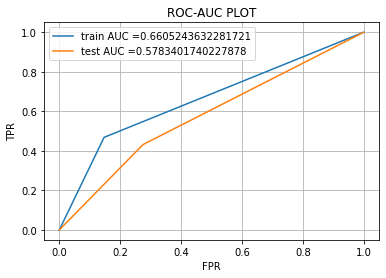

In [53]:
#depth=10
#min_samples_split=500
dt_f=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=500, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight='balanced', presort='deprecated', ccp_alpha=0.0)
dt_f.fit(x_tr_tfidf,y_train)
y_tr_pred=dt_f.predict(x_tr_tfidf)
y_te_pred=dt_f.predict(x_te_tfidf)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_tr_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_te_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC PLOT")
plt.grid()
plt.show()

####Model_training_for set2

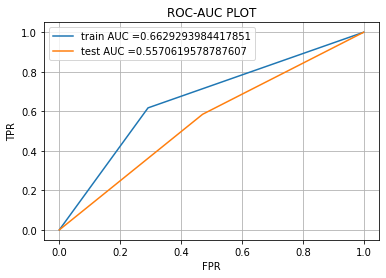

In [54]:
#depth=10
#min_samples_split=500
dt_f=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=500, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight='balanced', presort='deprecated', ccp_alpha=0.0)
dt_f.fit(x_tr_tfidf_w2v,y_train)
y_tr_pred_w2v=dt_f.predict(x_tr_tfidf_w2v)
y_te_pred_w2v=dt_f.predict(x_te_tfidf_w2v)
train_fpr_w2v, train_tpr_w2v, tr_thresholds_w2v = roc_curve(y_train, y_tr_pred_w2v)
test_fpr_w2v, test_tpr_w2v, te_thresholds_w2v = roc_curve(y_test, y_te_pred_w2v)
plt.plot(train_fpr_w2v, train_tpr_w2v, label="train AUC ="+str(auc(train_fpr_w2v, train_tpr_w2v)))
plt.plot(test_fpr_w2v, test_tpr_w2v, label="test AUC ="+str(auc(test_fpr_w2v, test_tpr_w2v)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC PLOT")
plt.grid()
plt.show()

####Model Evalution(Set1)_confusionMatrix

the maximum value of tpr*(1-fpr) 0.399334172866313 for threshold 1


Text(0.5, 1.0, 'Test_Confusion matrix')

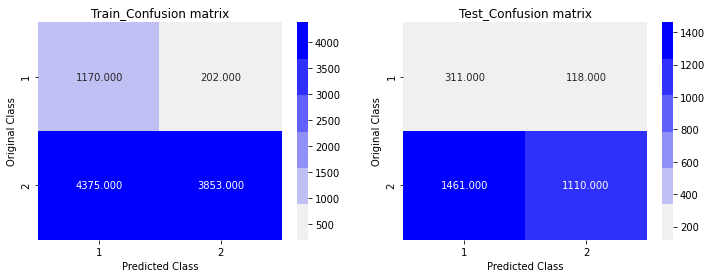

In [55]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
#print("Train confusion matrix")
plt.figure(figsize=(12,4))
A=confusion_matrix(y_train, predict_with_best_t(y_tr_pred, best_t))
labels = [1,2]
    # representing A in heatmap format
cmap=sns.light_palette("blue")
plt.subplot(1, 2, 1)
sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Train_Confusion matrix")
#print("Test confusion matrix")
B=confusion_matrix(y_test, predict_with_best_t(y_te_pred, best_t))
cmap=sns.light_palette("blue")
plt.subplot(1, 2, 2)
sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Test_Confusion matrix")

####Model Evalution(Set2)_confusionMatrix

the maximum value of tpr*(1-fpr) 0.4374028241757151 for threshold 1


Text(0.5, 1.0, 'Test_Confusion matrix_TFIDF_W2V')

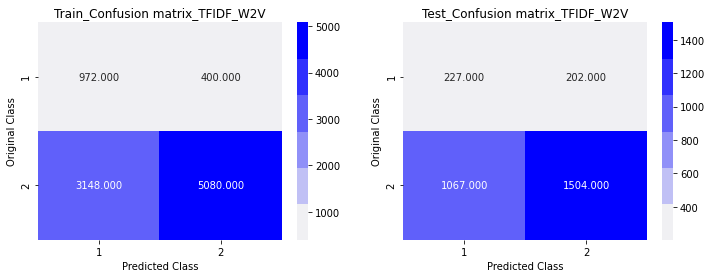

In [56]:
best_t_w2v = find_best_threshold(tr_thresholds_w2v, train_fpr_w2v, train_tpr_w2v)
#print("Train confusion matrix")
plt.figure(figsize=(12,4))
A=confusion_matrix(y_train, predict_with_best_t(y_tr_pred_w2v, best_t_w2v))
labels = [1,2]
    # representing A in heatmap format
cmap=sns.light_palette("blue")
plt.subplot(1, 2, 1)
sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Train_Confusion matrix_TFIDF_W2V")
#print("Test confusion matrix")
B=confusion_matrix(y_test, predict_with_best_t(y_te_pred_w2v, best_t_w2v))
cmap=sns.light_palette("blue")
plt.subplot(1, 2, 2)
sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Test_Confusion matrix_TFIDF_W2V")

####False_positive_data_points

In [57]:
#fp=[]
#import pandas 

#fp=df.where(x_te_tfidf((y_test==0)==(y_te_pred==1)==True))
import numpy as np
false_positives = np.logical_and(y_test != y_te_pred, y_te_pred == 1)
false_pos=x_te_tfidf[false_positives]
#print(false_pos)
keys=[]
values=[]
print(type(false_pos))
for i in range(118):
  keys.append(i)
  value_1=false_pos[i].indices
  values.append(value_1)
#print(keys)
#print(values)
new = {keys[i]: values[i] for i in range(len(values))}
#print(new)

<class 'scipy.sparse.csr.csr_matrix'>


In [58]:
y_pred= predict_with_best_t(y_te_pred, best_t)  
print(type(x_test))
false_positive=[]
for i in range(0, len(y_test)):
    if y_test[i]==0 and y_pred[i]==1:
        false_positive.append(x_test.iloc[i,])
print(len(false_positive))
#print(false_positive)
essay_str=[]
price_bxt=[]
teacher_number_of_previously_posted_projects_bxt=[]
for i in range(len(false_positive)):
  p=false_positive[i]
  e=p[6]
  pr=p[7]
  tr=p[3]
  essay_str.append(e)
  price_bxt.append(pr)
  teacher_number_of_previously_posted_projects_bxt.append(tr)
#print(false_positive['essay'])
#essay_str=str.join(false_positive['essay'])
print(essay_str)
essay_join="".join(essay_str)
print(essay_join)

<class 'pandas.core.frame.DataFrame'>
118
['technology campfire around tell stories laurie anderson in technology lab teach students effectively use technology enhance understanding world this includes research various topics using technology creatively tell stories our school urban low income neighborhood district 42 residents live poverty line despite disadvantage school provides students great opportunities may not otherwise this donors choose project give tools overcome socioeconomic barriers our students bright children love take photos make videos they enthusiastic telling stories lives lives important achievers history makers examples video projects teach students plan organize write communicate collaborate analyze in fact video become prolific colleges even include video submissions part application process as media matures students may need able express effectively moving imagery written word using video school could simple recording student oral presentation future review ela

#### WordCloud with the words of essay text of these `false positive data points`

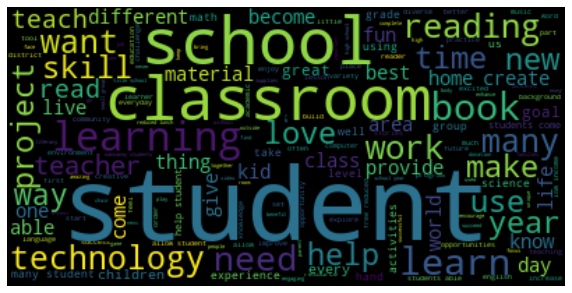

In [59]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.figure(figsize=(10,10))
wordcloud = WordCloud().generate(essay_join)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


####box plot with the `price` of these `false positive data points`

       price
0     736.62
1     390.97
2     591.88
3     549.90
4    1084.83
..       ...
113  3199.99
114   724.40
115   121.27
116    95.85
117   566.40

[118 rows x 1 columns]


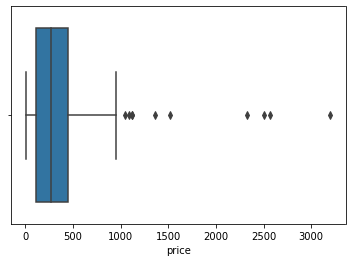

In [60]:
df = pd.DataFrame(price_bxt,columns=['price'])
print(df)
sns.boxplot(x='price',y=None,data=df)
plt.show()

pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points

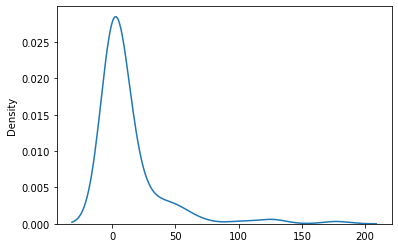

In [61]:
sns.distplot(a=teacher_number_of_previously_posted_projects_bxt, bins=None, hist=False, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None, x=None)
plt.show()

###TASK-2

In [63]:
from sklearn.inspection import permutation_importance
clf=DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=500,max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight='balanced')
clf.fit(x_tr_tfidf,y_train)
fi=permutation_importance(clf,x_tr_tfidf.toarray(),y_train,n_repeats=5, n_jobs=-1, random_state=None)



####Extracting Non-zero Features

In [64]:
print(type(fi))
feature_importance_all=fi['importances']
print(type(feature_importance_all))
feature_importance_non_zero_indices= np.where(feature_importance_all!=0) 
feature_indices=list(set(feature_importance_non_zero_indices[0]))
feature_values=feature_importance_all[feature_importance_non_zero_indices]

#print(feature_values) 

#feature_values=feature_importance_all.indices
#print(feature_values)
#feature_importance_non_zero=[i for i in feature_importance_all if i != 0]

<class 'sklearn.utils.Bunch'>
<class 'numpy.ndarray'>


####Model shape

In [65]:
x_tr_task2=x_tr_tfidf[:,feature_indices]
x_cv_task2=x_cv_tfidf[:,feature_indices]
x_te_task2=x_te_tfidf[:,feature_indices]
print(x_tr_task2.shape)
print(x_cv_task2.shape)
print(x_te_task2.shape)

(9600, 67)
(2400, 67)
(3000, 67)


####Hyperparameter Tunning

In [66]:
auc_score=[]
depth= [1, 5, 10, 50]
min_samples_split=[5,10,100,500]
Decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
#decision_tree.fit(x_tr_tfidf,y_train)
param_dict={'max_depth':[1, 5, 10, 50],'min_samples_split':[5,10,100,500]}

grid=GridSearchCV(Decision_tree,param_grid=param_dict,cv=10,verbose=1,n_jobs=-1,scoring='roc_auc',return_train_score=True)
#alpha_n_tfidf=[math.log(y,10) for y in alpha] 
grid.fit(x_tr_task2,y_train) 
print(grid.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   18.1s finished


{'max_depth': 50, 'min_samples_split': 500}


####Model Training

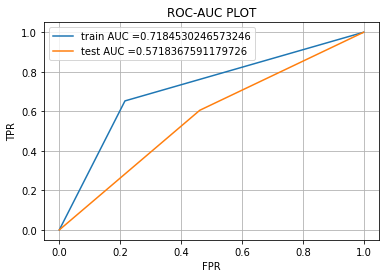

In [67]:
dt_f=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=50, min_samples_split=500, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight='balanced', presort='deprecated', ccp_alpha=0.0)
dt_f.fit(x_tr_task2,y_train)
y_tr_pred_task2=dt_f.predict(x_tr_task2)
y_te_pred_task2=dt_f.predict(x_te_task2)
train_fpr_2, train_tpr_2, tr_thresholds_2 = roc_curve(y_train, y_tr_pred_task2)
test_fpr_2, test_tpr_2, te_thresholds_2 = roc_curve(y_test, y_te_pred_task2)
plt.plot(train_fpr_2, train_tpr_2, label="train AUC ="+str(auc(train_fpr_2, train_tpr_2)))
plt.plot(test_fpr_2, test_tpr_2, label="test AUC ="+str(auc(test_fpr_2, test_tpr_2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC PLOT")
plt.grid()
plt.show()

####Model Evalution

the maximum value of tpr*(1-fpr) 0.511844643406359 for threshold 1


Text(0.5, 1.0, 'Test_Confusion matrix')

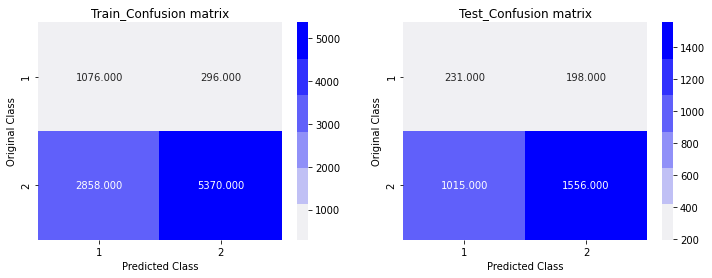

In [68]:
best_t_2 = find_best_threshold(tr_thresholds_2, train_fpr_2, train_tpr_2)
#print("Train confusion matrix")
plt.figure(figsize=(12,4))
A_2=confusion_matrix(y_train, predict_with_best_t(y_tr_pred_task2, best_t_2))
labels = [1,2]
    # representing A in heatmap format
cmap=sns.light_palette("blue")
plt.subplot(1, 2, 1)
sns.heatmap(A_2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Train_Confusion matrix")
#print("Test confusion matrix")
B_2=confusion_matrix(y_test, predict_with_best_t(y_te_pred_task2, best_t_2))
cmap=sns.light_palette("blue")
plt.subplot(1, 2, 2)
sns.heatmap(B_2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Test_Confusion matrix")

####Result_Table

In [69]:
from prettytable import PrettyTable

l = [["TFIDF",'Decision Tree',"50",'500', auc(test_fpr, test_tpr)], ["TFIDF_W2V",'Decision Tree',"10",'500' ,auc(test_fpr_w2v, test_tpr_w2v)]]

table = PrettyTable(['Vectorizer', 'Model', 'HyperParameter_Max_Depth','Hyperparameter_min_sample_split',"AUC Score"])

for rec in l:
    table.add_row(rec)
    
print(table)

+------------+---------------+--------------------------+---------------------------------+--------------------+
| Vectorizer |     Model     | HyperParameter_Max_Depth | Hyperparameter_min_sample_split |     AUC Score      |
+------------+---------------+--------------------------+---------------------------------+--------------------+
|   TFIDF    | Decision Tree |            50            |               500               | 0.5783401740227878 |
| TFIDF_W2V  | Decision Tree |            10            |               500               | 0.5570619578787607 |
+------------+---------------+--------------------------+---------------------------------+--------------------+


####SUMMARY
1. TFIDF is better technique as it display better confusion matrix
2. Projects which have low price values tends to misclassified most.
3. Teachers which have less experience(did less than 40  number of projects) tends to misclassified  as get approval for projects
4. TFIDF have less false positive data points .
